## Final Project Submission

Please fill out:
* Student name: Uma Palaniappan
* Student pace: Part Time 
* Scheduled project review date/time: June 24, 2019 
* Instructor name: Jeff Herman
* Blog post URL: https://umapalam.github.io/


### Introduction

The goal of this project is to build a regression model that can predict housing prices. The data provids a list of houses located in King County and their attributes.  

### Import Libraries 

Importing all the libraries in one place keeps the code more organized. Libraries are used in order to load and analyze data and also to create visualizations.

In [1]:
import pandas as pd
import numpy as np
import json
import os
import math
import random

from scipy import stats
from scipy import linalg

import statsmodels.api as sm
import statsmodels.stats.stattools as sms
from statsmodels.formula.api import ols

from sklearn import metrics
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 



### Introduce Data

In [2]:
# pandas DataFrame
df = pd.read_csv("kc_house_data.csv")

In [3]:
# .describe() function: Shows the characteristics of the data
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
# .shape: Shows the dimensions of the data
df.shape

(21597, 21)

In [5]:
# .columns: Lists all the columns in the dataset
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Stepwise Selection

A regression model is first emptied using stepwise selection. A new variable with the current lowest p-value is added to the model. This is called a forward step. After adding a new variable each time the algorithm looks at all the preceding p-values that were added to the model and removes them if that p-value is higher than a certain value. This is known as a backward step. This selection stops when there are no more new variables and their respective p-values added. 

In [6]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """
    Used to do a forward and backward steps based on p-values from statsmodels.api.OLS
    """

    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()

        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()

        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        # null if pvalues is empty
        worst_pval = pvalues.max()

        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)

            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break

    return included


### Data Cleaning

In [7]:
# Check datatypes using .info() function
# Make sure the data is numerical so that the machine learning methods can work without error
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


The variables 'date' and 'sqft_basement' are objects.

In [8]:
# .isnull() shows what amont of missing data need to be dealt with 
percent_missing = df.isnull().sum() * 100 / len(df)
print(percent_missing)

id                0.000000
date              0.000000
price             0.000000
bedrooms          0.000000
bathrooms         0.000000
sqft_living       0.000000
sqft_lot          0.000000
floors            0.000000
waterfront       11.001528
view              0.291707
condition         0.000000
grade             0.000000
sqft_above        0.000000
sqft_basement     0.000000
yr_built          0.000000
yr_renovated     17.789508
zipcode           0.000000
lat               0.000000
long              0.000000
sqft_living15     0.000000
sqft_lot15        0.000000
dtype: float64


In [9]:
df.view.fillna(0, inplace=True)

Change yr_renovated variable to integer and replace missing values in view

In [10]:
import datetime
time = datetime.datetime.now().year

def years(row):
    return time - row['yr_renovated'] if row['yr_renovated'] > 0 else 0

def ren2(row):
    return 1 if row['sinren'] > 0 or row['sqft_living'] != row['sqft_living15'] else 0

df.yr_renovated.fillna(0, inplace = True)
df.yr_renovated = df.yr_renovated.astype('int64')

df['sinren'] = df.apply(years, axis = 1)

df['isren'] = df.apply(ren2, axis = 1)

# Binning
bins = [0., 1950., 1980., 1990., 2000., 2015.]
names = ['never', 'pre 1980', '1980-1989', '1990-1999', '2000-2015']
df['renbins'] = pd.cut(df['yr_renovated'], bins, labels=names, right=False)
df.renbins.fillna('never', inplace=True)

df.drop(columns=['yr_renovated'], inplace=True)

In [11]:
df.yr_built.value_counts().head()

2014    559
2006    453
2005    450
2004    433
2003    420
Name: yr_built, dtype: int64

In [12]:
df['age'] = time - df.yr_built

Making a new variable that shows how long the house has been built. 

In [13]:
df['built'] = df['age'].apply(lambda x: ('old' if x >= 50 else 'middle') if x >= 15 else 'new')

df['built'] = pd.Categorical(df['built'], categories = ['old', 'middle', 'new'])
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,sinren,isren,renbins,age,built
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,98178,47.5112,-122.257,1340,5650,0,1,never,64,old
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,98125,47.7210,-122.319,1690,7639,28,1,1990-1999,68,old


In [14]:
df.built.value_counts()

old       10043
middle     8396
new        3158
Name: built, dtype: int64

In [15]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
sinren              0
isren               0
renbins             0
age                 0
built               0
dtype: int64

In [16]:
print(df.waterfront.isnull().sum() / df.shape[0])

0.11001527989998611


In [17]:
df.waterfront.fillna(0, inplace=True)

Instead of dropping the waterfront variable as I did before when manipulating the data, I decided to just replace the values. 

In [18]:
def base(row):
    """
    Used to calculate basement sqft based on the difference between the variables sqft_living and sqft_above

    """
    return row['sqft_living'] - row['sqft_above'] if row['sqft_above'] < row['sqft_living']  else 0

df.sqft_basement = df.apply(base, axis = 1)

Before I would replace the '?' with the mean of the sqft_basement variable, but now I wanted to use the difference between two other similar variables in order to counter it. 

In [19]:
# Final check of null values 
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
sinren           0
isren            0
renbins          0
age              0
built            0
dtype: int64

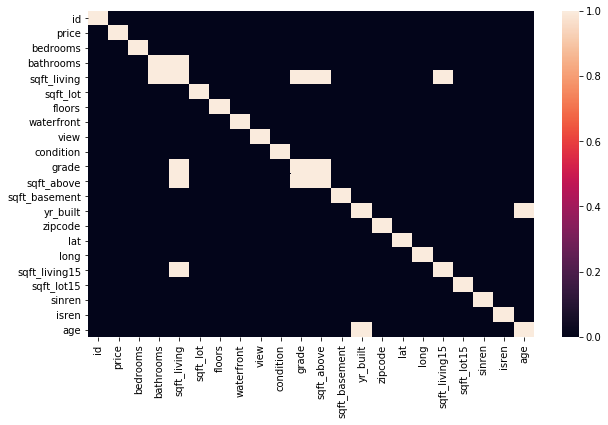

In [20]:
# Use a heatmap from seaborn 
plt.figure(figsize = (10,6))
sns.heatmap(abs(df.corr())>.75)

In [21]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,sinren,isren,age
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.003599,0.011772,-0.023803,...,-0.005193,0.021617,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,-0.009404,-0.025426,-0.021617
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.264306,0.393497,0.036056,...,0.323799,0.053953,-0.053402,0.306692,0.022036,0.585241,0.082845,0.074337,0.067126,-0.053953
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.078354,0.026496,...,0.302808,0.155670,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.004405,0.034688,-0.155670
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,0.186016,-0.126479,...,0.283440,0.507173,-0.204786,0.024280,0.224903,0.569884,0.088303,0.007418,-0.014099,-0.507173
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,0.281715,-0.059445,...,0.435130,0.318152,-0.199802,0.052155,0.241214,0.756402,0.184342,0.025328,0.061875,-0.318152
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,0.075054,-0.008830,...,0.015418,0.052946,-0.129586,-0.085514,0.230227,0.144763,0.718204,0.012155,0.037669,-0.052946
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,0.028414,-0.264075,...,-0.245715,0.489193,-0.059541,0.049239,0.125943,0.280102,-0.010722,-0.002691,-0.106568,-0.489193
waterfront,-0.003599,0.264306,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.380543,0.016648,...,0.082800,-0.024487,0.028923,-0.012157,-0.037628,0.083823,0.030658,0.084425,0.021068,0.024487
view,0.011772,0.393497,0.078354,0.186016,0.281715,0.075054,0.028414,0.380543,1.000000,0.045622,...,0.273845,-0.054452,0.085059,0.006321,-0.077702,0.278928,0.073083,0.084399,0.035234,0.054452
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,0.045622,1.000000,...,0.173849,-0.361592,0.002888,-0.015102,-0.105877,-0.093072,-0.003126,-0.015174,0.062011,0.361592


In [22]:
abs(df.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,sinren,isren,age
id,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In general a correlation with an absolute value from '0.7' or higher is considered a high correlation. I have set the limit here to be '.75'

### Data Exploration

Focus Questions:
- Do larger basements sell more?
- What grade of house is sold at the highest price?
- Do larger living spaces sell at higher prices?

The reasons why I am focusing on these questions are because I am curious to see if houses sell at higher prices. If more space in square feet entice people to buy a house. I want to see if the grade of a house can affect the price and what grade was the most commonly bought. I also am curious to see if more people buy houses in the summer months rather than the winter months.

In [23]:
df['sqft_basement'].value_counts().head()

0      13110
600      221
700      218
500      214
800      206
Name: sqft_basement, dtype: int64

In [24]:
df['sqft_basement'].quantile(.33)

0.0

In [25]:
df['sqft_basement'].quantile(.66)

300.0

In [26]:
my_list = []

for x in df['sqft_basement']:
    if x < df['sqft_basement'].quantile(.33):
        my_list.append('small')
    elif x >= (df['sqft_basement'].quantile(.33)) and (x < df['sqft_basement'].quantile(.66)):
        my_list.append('small')
    else:
         my_list.append('large')
            
df['sqft_basement_categories'] = my_list

In [27]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,sinren,isren,renbins,age,built,sqft_basement_categories
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,47.5112,-122.257,1340,5650,0,1,never,64,old,small
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,47.7210,-122.319,1690,7639,28,1,1990-1999,68,old,large
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,47.7379,-122.233,2720,8062,0,1,never,86,old,small
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,47.5208,-122.393,1360,5000,0,1,never,54,old,large
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,47.6168,-122.045,1800,7503,0,1,never,32,middle,small


Text(0.5, 1.0, 'Size of Basement')

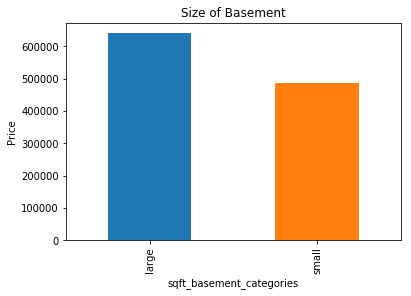

In [28]:
my_plot = df.groupby('sqft_basement_categories')['price'].mean().plot(kind = 'bar')
my_plot.set_ylabel('Price')
my_plot.set_title('Size of Basement')

In [29]:
df.drop(['sqft_basement_categories'], axis=1).head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,sinren,isren,renbins,age,built
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,98178,47.5112,-122.257,1340,5650,0,1,never,64,old
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,98125,47.7210,-122.319,1690,7639,28,1,1990-1999,68,old
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,98028,47.7379,-122.233,2720,8062,0,1,never,86,old
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,98136,47.5208,-122.393,1360,5000,0,1,never,54,old
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,98074,47.6168,-122.045,1800,7503,0,1,never,32,middle


In [30]:
df['sqft_basement'].mean()

291.72500810297726

Basements that are larger in square feet sold for more money compared to basements that were smaller. A lot of houses did not have basements at all as indicated by the value '0.0'.

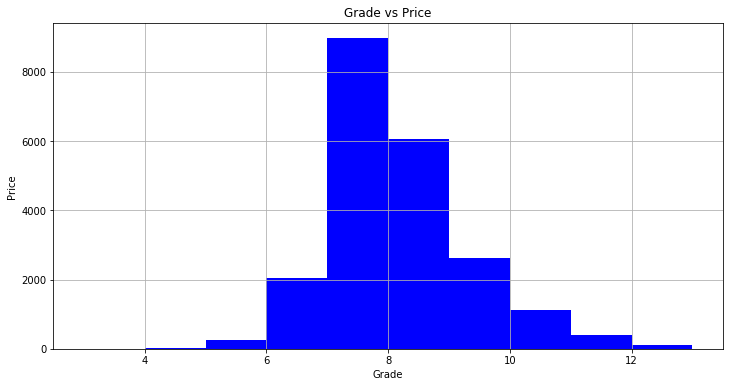

In [31]:
df['grade'].hist(figsize=(12,6), color= 'blue')
plt.title('Grade vs Price')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.show()

The grade of house that is sold the most is grade '7'. This is interesting because I would think that grade '10' or higher would sell the most houses because it has been judged to be a higher quality. This variable will have to be dropped before doing the regression as it demonstrates a high correlation with other variables such as 'sqft_living'.

In [32]:
df['sqft_living'].mean()

2080.3218502569803

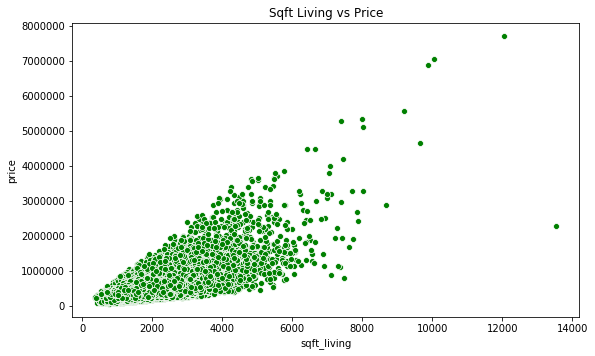

In [33]:
plt.figure(figsize=(20,20))

plt.subplot(321)
sns.scatterplot(df.sqft_living, df.price, color ='green')

plt.title('Sqft Living vs Price')

plt.subplots_adjust(hspace = 0.35)
plt.show()

There is a strong positive correlation shown in this visualization between price and sqft_living. There are some outliers in this graph.

### Dummy Variables

In [34]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sinren', 'isren', 'renbins', 'age',
       'built', 'sqft_basement_categories'],
      dtype='object')

In [35]:
df['zipcode'] = df['zipcode'].astype(int)

In [36]:
df['condition'] = df['condition'].astype('category', ordered = True)
df['waterfront'] = df['waterfront'].astype('category', ordered = True)
df['isren'] = df['isren'].astype('category', ordered = False)
df['view'] = df['view'].astype('category', ordered = False)

# Create variable 'newbase'
df['newbase'] = df.sqft_basement.apply(lambda x: 1 if x > 0 else 0)
df['newbase'] = df.newbase.astype('category', ordered = False)

In [37]:
# Set dummies
newcolumns = ['view', 'condition', 'waterfront', 'isren', 'newbase']

for col in newcolumns:
    dummies = pd.get_dummies(df[col])
    dummies = dummies.add_prefix("{}_".format(col))
    
    df.drop(col, axis=1, inplace=True)
    df = df.join(dummies)
    
for col in df.columns:
    if col.find('.') != -1: 
        df.rename(columns={col: col.replace('.', '_')}, inplace=True)

### Dropping Variables 

In [38]:
df.drop(['id', 'date', 'lat', 'long'], axis = 1, inplace = True)

In [39]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,...,condition_2,condition_3,condition_4,condition_5,waterfront_0_0,waterfront_1_0,isren_0,isren_1,newbase_0,newbase_1
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,...,0,1,0,0,1,0,0,1,1,0
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,...,0,1,0,0,1,0,0,1,0,1
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,...,0,1,0,0,1,0,0,1,1,0
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,...,0,0,0,1,1,0,0,1,0,1
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,...,0,1,0,0,1,0,0,1,1,0


### Scaling and Normalization

In [40]:
# Minmax scaling
minmax_df = df[['age', 'zipcode']]

scaler = preprocessing.MinMaxScaler()
minmax_scaled_df = scaler.fit_transform(minmax_df)
minmax_scaled_df = pd.DataFrame(minmax_scaled_df, columns=['age', 'zipcode'])

In [41]:
# Robust scaling
robust_df = df[['price', 'sqft_above', 'sqft_living15', 'sqft_lot15']]

scaler = preprocessing.RobustScaler()
robust_scaled_df = scaler.fit_transform(robust_df)
robust_scaled_df = pd.DataFrame(robust_scaled_df, columns=['price', 'sqft_above', 'sqft_living15', 'sqft_lot15'])

In [42]:
dataset_ols = pd.concat([df[['grade', 'bedrooms', 'bathrooms', 'condition_3', 'condition_4', 
                                  'condition_5']], minmax_scaled_df, robust_scaled_df], axis=1)

In [43]:
dataset_ols.head()

,grade,bedrooms,bathrooms,condition_3,condition_4,condition_5,age,zipcode,price,sqft_above,sqft_living15,sqft_lot15
0,7,3,1.00,1,0,0,0.521739,0.893939,-0.706192,-0.372549,-0.574713,-0.395344
1,7,3,2.25,1,0,0,0.556522,0.626263,0.272446,0.598039,-0.172414,0.003813
2,6,2,1.00,1,0,0,0.713043,0.136364,-0.835913,-0.774510,1.011494,0.088702
3,7,4,3.00,0,0,1,0.434783,0.681818,0.476780,-0.500000,-0.551724,-0.525788
4,8,3,2.00,1,0,0,0.243478,0.368687,0.185759,0.117647,-0.045977,-0.023480


### Outliers

An outlier is when one data point is extremely different from the other gathered data points. This could cause errors in data analysis because it could skew the data and obscure the true results.

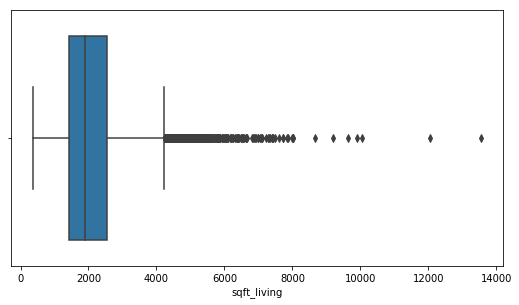

In [44]:
plt.figure(figsize=(30,16))
plt.subplot(331)
sns.boxplot(df.sqft_living)

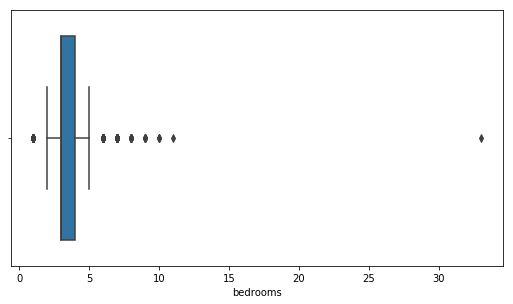

In [45]:
plt.figure(figsize=(30,16))
plt.subplot(331)
sns.boxplot(df.bedrooms)

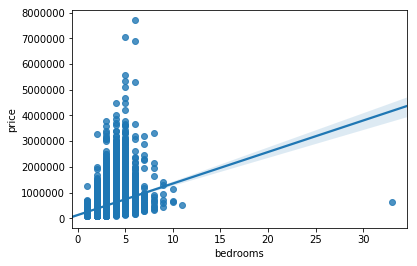

In [46]:
sns.regplot(x = 'bedrooms', y = 'price', data = df)

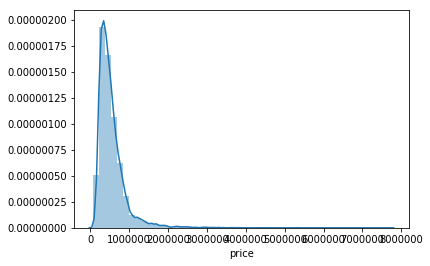

In [47]:
sns.distplot(df['price'])

### Model Regression

In [48]:
ols_results = []
if len(ols_results) != 1:
    ols_results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)']]

In [49]:
features = ['grade', 'bedrooms', 'bathrooms', 'age', 'sqft_above',
            'sqft_living15', 'sqft_lot15', 'zipcode', 'condition_3', 'condition_4', 'condition_5']

In [50]:
def run_ols_regression(store_results, data, target, feature, show_plots=False):
    """
    Run ols model, prints model summary, displays plot_regress_exog and qqplot
    
    """
    
    formula = target + '~' + feature
    model = ols(formula=formula, data=data).fit()

    df = pd.DataFrame({feature: [data[feature].min(), data[feature].max()]})
    pred = model.predict(df)

    if show_plots:
        print('Regression Analysis and Diagnostics for formula: ', formula)
        print('\n')

        fig = plt.figure(figsize=(16, 8))
        fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
        plt.show();

        residuals = model.resid
        fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
        fig.show();
    
    # append all information to results
    store_results.append([feature, model.rsquared, model.params[0], model.params[0],
                        model.pvalues[1], sms.jarque_bera(model.resid)[0]])

In [51]:
for feature in features:
    run_ols_regression(ols_results, dataset_ols, 'price', feature)

In [52]:
pd.DataFrame(ols_results)

,0,1,2,3,4,5
0,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,grade,0.446158,-4.67931,-4.67931,0,2.0439e+06
2,bedrooms,0.0953497,-0.999382,-0.999382,0,1.1951e+06
3,bathrooms,0.276577,-1.36621,-1.36621,0,882736
4,age,0.00291096,0.371472,0.371472,2.11758e-15,1.14251e+06
5,sqft_above,0.36647,0.0894112,0.0894112,0,728366
6,sqft_living15,0.342507,0.137129,0.137129,0,1.91058e+06
7,sqft_lot15,0.00686328,0.261805,0.261805,3.30159e-34,1.14233e+06
8,zipcode,0.00285182,0.366897,0.366897,4.0579e-15,1.12339e+06
9,condition_3,4.82789e-05,0.268806,0.268806,0.307221,1.13165e+06


In [53]:
y = dataset_ols['price']
X = dataset_ols.drop(['price'], axis=1)

In [54]:
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

Add  grade                          with p-value 0.0
Add  age                            with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_above                     with p-value 5.15909e-193
Add  sqft_living15                  with p-value 8.5384e-68
Add  bedrooms                       with p-value 5.85247e-31
Add  condition_5                    with p-value 8.56348e-18
Add  sqft_lot15                     with p-value 1.80107e-09
Add  zipcode                        with p-value 8.1134e-08
Add  condition_4                    with p-value 5.63524e-10
resulting features:
['grade', 'age', 'bathrooms', 'sqft_above', 'sqft_living15', 'bedrooms', 'condition_5', 'sqft_lot15', 'zipcode', 'condition_4']


In [55]:
pred = '+'.join(features)
formula = 'price~' + pred

In [56]:
model = ols(formula=formula, data=dataset_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2854.
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:09:01   Log-Likelihood:                -23729.
No. Observations:               21597   AIC:                         4.748e+04
Df Residuals:                   21585   BIC:                         4.758e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.4380      0.077    -57.998      0.000      -4.588      -4.288
grade             0.4542      0.007     61.568      0.000       0.440       0.469
bedrooms         -0.0802      0.007    -12.272      0.000      -0.093      -0.067
bathrooms         0.3433      0.010     33.064      0.000       0.323       0.364
age               1.6019      0.026     61.264      0.000       1.551       1.653
sqft_above        0.2782      0.011     24.681      0.000       0.256       0.300
sqft_living15     0.1948      0.010     19.297      0.000       0.175       0.215
sqft_lot15       -0.0053      0.001     -5.690      0.000      -0.007      -0.003
zipcode           0.1305      0.021      6.359      0.000       0.090       0.171
condition_3      -0.0056      0.052     -0.106      0.915      -0.108       0.097
condition_4       0.0707      0.053      1.343      0.179      -0.032       0.174
condition_5       0.1954      0.055      3.569      0.000       0.088       0.303
==============================================================================
Omnibus:                    19331.926   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1954163.556
Skew:                           3.894   Prob(JB):                         0.00
Kurtosis:                      48.945   Cond. No.                         194.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
y = dataset_ols['price']
X = dataset_ols.drop(['price', 'sqft_above', 'condition_3', 'condition_4'], axis=1)

In [58]:
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     3737.
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:09:01   Log-Likelihood:                -24038.
No. Observations:               21597   AIC:                         4.809e+04
Df Residuals:                   21588   BIC:                         4.817e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.0863      0.054    -94.122      0.000      -5.192      -4.980
grade             0.5184      0.007     74.286      0.000       0.505       0.532
bedrooms         -0.0461      0.006     -7.116      0.000      -0.059      -0.033
bathrooms         0.3992      0.010     38.904      0.000       0.379       0.419
condition_5       0.1458      0.019      7.542      0.000       0.108       0.184
age               1.6185      0.025     63.896      0.000       1.569       1.668
zipcode           0.0817      0.020      3.991      0.000       0.042       0.122
sqft_living15     0.2782      0.010     28.844      0.000       0.259       0.297
sqft_lot15       -0.0022      0.001     -2.367      0.018      -0.004      -0.000
==============================================================================
Omnibus:                    20383.740   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2520055.507
Skew:                           4.192   Prob(JB):                         0.00
Kurtosis:                      55.251   Cond. No.                         99.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Train Test Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [60]:
# Fitting the model 
linreg = LinearRegression().fit(X_train, y_train)

# Preditors on the train and test set
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [61]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [62]:
# Mean squared error is a measure of how close a fitted line is to data points
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.5385015397842428
Test Mean Squarred Error: 0.5586970562132875


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [64]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns =['Coefficient'])
coeff_df

,Coefficient
grade,0.526347
bedrooms,-0.040697
bathrooms,0.400249
condition_5,0.149980
age,1.622665
zipcode,0.077582
sqft_living15,0.279793
sqft_lot15,-0.002738


In [65]:
y_pred = regressor.predict(X_test)

In [66]:
dfl = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dfl.head()

,Actual,Predicted
156,0.619195,1.313063
15572,0.541796,0.568612
2080,1.153251,1.640251
17522,-0.836223,-0.889333
8360,-0.247678,1.356522


In [67]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.45459291587486234
Mean Squared Error: 0.46520089828403843
Root Mean Squared Error: 0.6820563747110927


### Conclusion

Initially the model was only 48% accurate across all the data so it was not a good model. Some mistakes were most likely made during the scaling process. The min-max scaling to be specific. I am pretty sure that the data cleaning went correctly. I also eliminated too many variables the first time around. I attempted to improve the model by getting rid of some outliers but that had little to no effect on the model as it only got a 1% increase in model accuracy. So it was 49% accurate. I attempted to replace the variables I had with other ones until I found that I needed to include variables such as condition and grade. Before I also eliminated yr_renovated and yr_built which seems to have made a difference to the data, because of that I added it back into the dataset and manipulated it. 

My final regression has an r-value of 58% which is a ten point increase from earlier attempts. I thought that size of the space mattered more when it came to the price of a house but I was incorrect. Size of the house was important but there were other features that could have improved this model, such as condition and the age of a house.

Some suggestions I have for people buying houses in King County would be to take into account the quality or condition of a house first because that impacts the price significantly. 